In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tnrange
%matplotlib inline

In [4]:
class Bandit:

    
    def __init__(self, k_arm=10, epsilon=0.0, initial=0.0, step_size=0.1):
        self.k = k_arm
        self.step_size = step_size
        self.indices = np.arange(self.k)
        self.time = 0
        self.average_reward = 0
        self.epsilon = epsilon
        self.initial = initial

        
    def reset(self):
        # real reward for each action N(µ=0, σ^2=1)
        self.q_true = np.random.randn(self.k)

        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

        # Number of chosen times for each action
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)
        self.time = 0
   

    def act(self):
        """
        Get an action for this bandit
        """
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    
    def step(self, action):
        """
        Take an action, update estimation for this action using a constant step size
        """
        # Produce a reward using N(µ=true reward, σ^2=1)
        reward = np.random.randn() + self.q_true[action]
        # Increment counters
        self.time += 1
        self.action_count[action] += 1
        # Update average reward received metric
        self.average_reward += (reward - self.average_reward) / self.time
        return reward
    
    
class SampleAverageActionValue:
    
    def __init__(self, bandit):
        self.bandit = bandit
        self.name = "Sample Average Action Value"

        
    def reset(self):
        self.bandit.reset()
        self.best_action = self.bandit.best_action

         
    def act(self):
        return self.bandit.act()       
        
    
    def step(self, action):
        reward = self.bandit.step(action)
        self.bandit.q_estimation[action] += (reward - self.bandit.q_estimation[action]) / self.bandit.action_count[action]
        return reward
    
    
class ConstantStepActionValue:
    
    def __init__(self, bandit):
        self.bandit = bandit
        self.name = "Constant Step Action Value"
        

    def reset(self):
        self.bandit.reset()
        self.best_action = self.bandit.best_action

        
    def act(self):
        return self.bandit.act()
    
        
    def step(self, action):
        reward = self.bandit.step(action)
        self.bandit.q_estimation[action] += self.bandit.step_size * (reward - self.bandit.q_estimation[action])
        return reward

In [5]:
import threading


def simulate(runs, time, bandits):
    """
    This still needs to be parallelized in a better way (The global shared lock is inefficient)
    Implement in a thread pool and split among bandits to capitalize on all host machine cores.
    """
    
    lock = threading.Lock()
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    
    
    def work(runs, time, bandit, idx):
        for run in tnrange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                
                with lock:
                    rewards[idx, run, t] = reward
                    if action == bandit.best_action:
                        best_action_counts[idx, run, t] = 1
    

    threads = list()
    for i, bandit in enumerate(bandits):
        t = threading.Thread(target=work, args=(runs, time, bandit, i))
        threads.append(t)
        t.start()
        
                             
    for idx, thread in enumerate(threads):
        thread.join()

    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

In [9]:
def show_agent_performance(bandits, rewards, best_action_counts):
    plt.figure(figsize=(12.5, 10))

    plt.subplot(2, 1, 1)
    for bandit, rewards in zip(bandits, rewards):
        plt.plot(rewards, label='bandit = %s' % (bandit.name))
    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.legend()

    plt.subplot(2, 1, 2)
    for bandit, counts in zip(bandits, best_action_counts):
        plt.plot(counts, label='bandit = %s' % (bandit.name))
    plt.xlabel('Steps')
    plt.ylabel('% Optimal Action')
    plt.legend()

# Violin Plot
---

Text(0, 0.5, 'Reward Distribution')

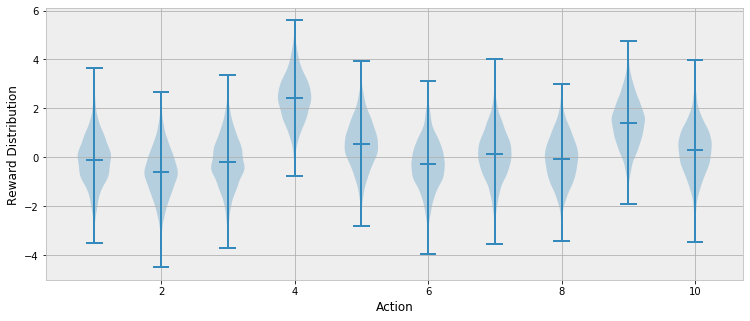

In [4]:
plt.figure(figsize=(12.5, 5))
plt.violinplot(dataset=np.random.randn(2000, 10) + np.random.randn(10), showmeans=True)
plt.xlabel("Action")
plt.ylabel("Reward Distribution")

# Figure 2.2
---

In [5]:
# If you only see HBOX HTML text output then run Jupyter notebook from project root to get progress bars
runs = 2000
time = 1000
epsilons = [0, 0.1, 0.01]
bandits = [SampleAverageActionValue(Bandit(epsilon=eps)) for eps in epsilons]
best_action_counts, rewards = simulate(runs, time, bandits)

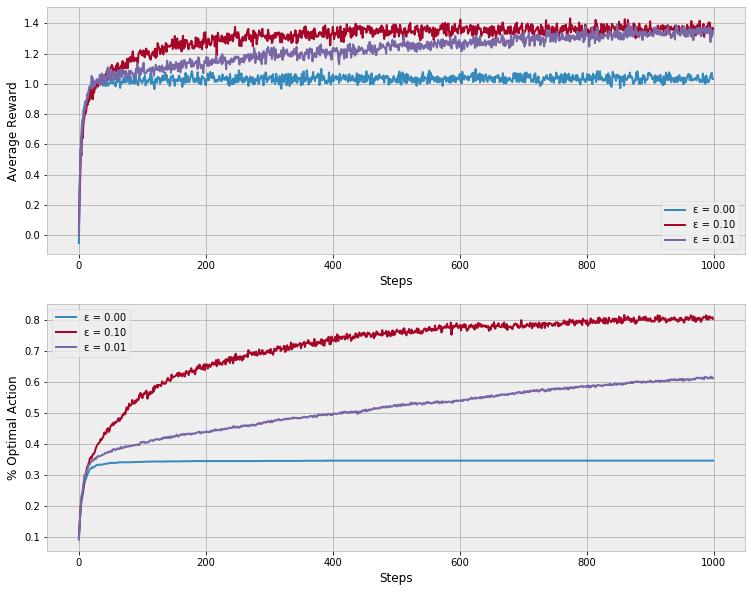

In [6]:
plt.figure(figsize=(12.5, 10))

plt.subplot(2, 1, 1)
for eps, rewards in zip(epsilons, rewards):
    plt.plot(rewards, label='ε = %.02f' % (eps))
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend()

plt.subplot(2, 1, 2)
for eps, counts in zip(epsilons, best_action_counts):
    plt.plot(counts, label='ε = %.02f' % (eps))
plt.xlabel('Steps')
plt.ylabel('% Optimal Action')
plt.legend()

## Exercise 2.4
---
If the step-size parameters, $ \propto_n $, are not constant, then the estimate $ Q_n $ is a weighted average of previously received rewards with a weighting different from that given by (2.6). What is the weighting on each prior reward for the general case, analogous to (2.6), in terms of the sequence of step-size parameters?  

\begin{equation*}
Q_{n+1}=(1 - \propto)^n Q_1 + \sum_{i=1}^{n}\propto(1-\propto)^{n-i}R_i \tag{2.6}
\end{equation*}

### Solution:
---
Let $ \propto_{n}(a) $ vary with time:

\begin{align*}
Q_{n+1}
&= Q_n + \propto_n[R_n - Q_n] \\
&= (1 - \propto_n)Q_n + \propto_nR_n \\
&= (1 - \propto_n)(\propto_{n-1}R_{n-1} + (1 - \propto_{n-1})Q_{n-1}) + \propto_nR_n \\
&= (1 - \propto_n)\propto_{n-1}R_{n-1} + (1 - \propto_n)(1 - \propto_{n-1})Q_{n-1} + \propto_nR_n \\
&= (1 - \propto_n)\propto_{n-1}R_{n-1} + (1 - \propto_n)^2\propto_nR_{n-2} + ... + (1 - \propto_n)^{n-1}\propto_nR_1  + (1 - \propto_n)^nQ_1 + \propto_nR_n \\
&= Q_1\prod_{i=1}^n(1 - \propto_i) + \sum_{i=1}^n(\propto_iR_i\prod_{j=i}^n(1 - \propto_j))
\end{align*}



## Exercise 2.5
---
Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the $ q_{*}(a) $ start out equal and then take independent random walks (say by adding a normally distributed increment with mean zero and standard deviation 0.01 to all the $ q_{*}(a) $ on each step).

Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, $ \propto=0.1 $. Use $ \epsilon=0.1 $ and longer runs, say of 10,000 steps.

In [6]:
class NonStationaryBandit(Bandit):
    
    def __init__(self, k_arm=10, epsilon=0.0, initial=0.0, step_size=0.1):
        super().__init__(k_arm, epsilon, initial, step_size)
    
    
    def reset(self):
        Bandit.reset(self)
        # real reward for each action (Start out equal)
        self.q_true = np.zeros(self.k) + self.initial
    
    
    def step(self, action):
        """ Each step have q*(a) take random walk sampled from N(µ=0, σ^2=0.01)"""
        reward = Bandit.step(self, action)
        # Increment all rewards to take a random walk
        µ = 0
        σ = 0.1 # sqrt σ^2
        self.q_true += σ * np.random.randn(self.q_true.size) + µ
        return reward

In [9]:
# If you only see HBOX HTML text output then run Jupyter notebook from project root to get progress bars
runs = 2000
time = 10000
initial_reward = 0
bandits = [ SampleAverageActionValue(NonStationaryBandit(epsilon=0.1, initial=initial_reward)),
            ConstantStepActionValue(NonStationaryBandit(epsilon=0.1, step_size=0.1, initial=initial_reward))
          ]
best_action_counts, rewards = simulate(runs, time, bandits)

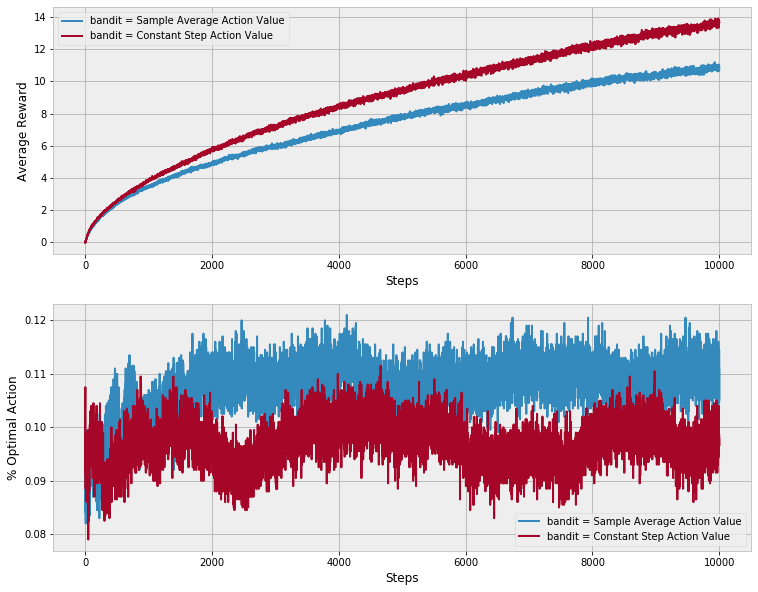

In [10]:
show_agent_performance(bandits, rewards, best_action_counts)

## Optimistic Initial Values
---

In [5]:
runs = 2000
time = 1000
bandits = [ ConstantStepActionValue(Bandit(epsilon=0, initial=5)),
            ConstantStepActionValue(Bandit(epsilon=0.1, initial=0))
          ]
best_action_counts, rewards = simulate(runs, time, bandits)

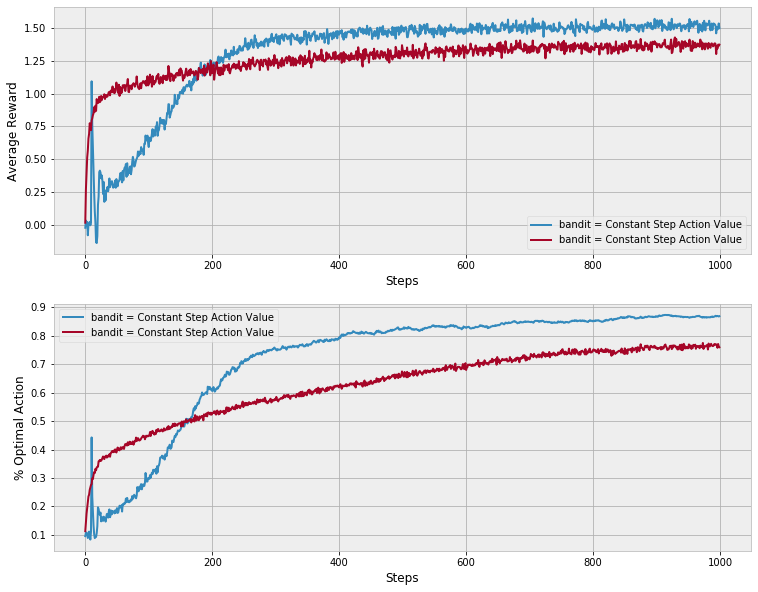

In [6]:
show_agent_performance(bandits, rewards, best_action_counts)

## Exercise 2.6: Mysterious Spikes
---
The results shown in Fig 2.3 should be quite reliable because they are averages over 2000 individual, randomly chosen 10-armed bandit tasks. Why, then, are there oscillations and spikes in the early part of the curve for the optimistic method? In other words, what might make this method perform particularly better or worse, on average, on particular early steps?

### Solution:

With an initial estimate of 5 and a stationary reward distribution given by:

\begin{equation*}
Q_{*}(a) \sim \mathcal{N}(\mu=0, \sigma^{2}=1)
\end{equation*}

During the first k steps of each run, the bandit will sample each available step at least once as there effectively no chance the sampled reward $ R_{n}(a) \sim \mathcal{N}(\mu=Q_{*}(a), \sigma^{2}=1) $ will be >= 5 for n <= k. As each sampled action during step $ \{ n | n <= k \} $ adjusts the expected reward downwards toward the true reward, after all estimates have been updated by each action on step $ n = k + 1 $ having been selected, the bandit has a strong probability of sampling the optimal action which explains the initial spike at $ step=k + 1=11 $. 

There is overlap in the reward distribution $ Q_{*}(a) $ so it is highly probable that the optimal action will sample lower than other actions and the greedy algorithm will act on them subsequently in early steps before estimates have annealed. As the sample size grows the expected return from the optimal action will more consistently be greater than the other actions and will be selected correctly more often in greater time steps.

## Exercise 2.7: Unbiased Constant Step Size Trick
---
Throughout most of the chapter we have used sample averages to estimate action values because sample averages do not produce the initial bias that constant step sizes do. However, sample averages are not a completely satisfactory solution because they may perform poorly on onstationary problems. Is it possible to avoid the bias of constant step sizes while on non-stationary problems? One way is to use a step size of:

\begin{equation*}
\beta_n \doteq \frac{\alpha}{\bar{o}_n}
\end{equation*}

to process the nth reward for a particular action, where $ \alpha > 0 $ is a conventional constant step size, and $ \bar{o}_n $ is a trace of one that starts at 0:

$ \bar{o}_n \doteq \bar{o}_{n-1} + \alpha(1 - \bar{o}_{n-1}) $ , for $ n \geq 0 $ , with $ \bar{o}_0 \doteq 0 $.

Carry out an analysis like that in (2.6) to show that $ Q_n $ is an exponential recency-weighted average *without initial bias*.

### Solution:
TODO

# Upper-Confidence-Bound Action Selection

In [7]:
class UCBActionValue(SampleAverageActionValue):
    
    def __init__(self, bandit, c):
        super().__init__(bandit)
        self.name = "UCB Action Value"
        self.c = c

         
    def act(self):
        # Add small number .0001 to prevent empty action count
        ucb_est = self.bandit.q_estimation + self.c * np.sqrt(np.log(self.bandit.time + 1)/(self.bandit.action_count + 1e-5))
        q_best = np.max(ucb_est)
        return np.random.choice(np.where(ucb_est == q_best)[0])

In [8]:
runs = 2000
time = 1000
bandits = [ UCBActionValue(Bandit(), 2),
            SampleAverageActionValue(Bandit(epsilon=0.1))
          ]
best_action_counts, rewards = simulate(runs, time, bandits)

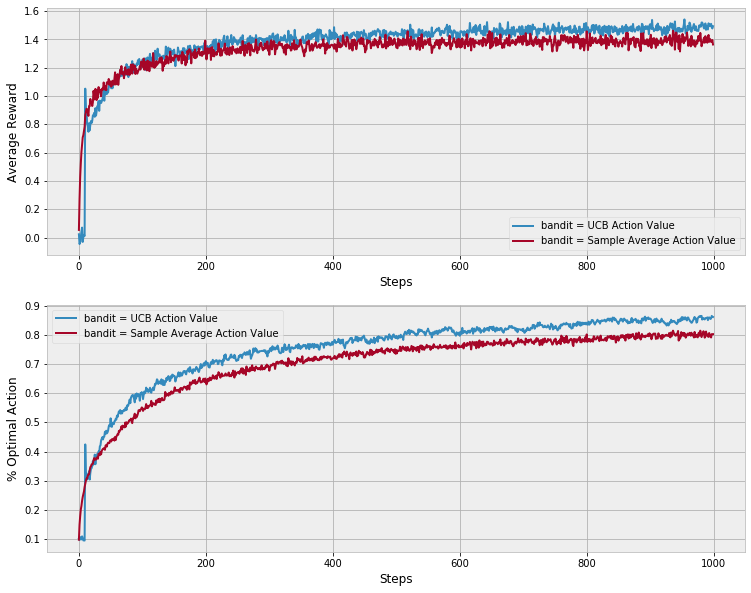

In [10]:
show_agent_performance(bandits, rewards, best_action_counts)

## Exercise 2.8: Mysterious Spikes
---
In the above figure the UCB algorithm shows a distinct spike in performance on the 11th step. Why is this?

### Solution:

The UCB algorithm is selecting actions according to:

\begin{equation*}
A_t \doteq \underset{a}{\mathrm{argmax}} \left[ \hspace{0.5em} Q_t(a) + c  \sqrt{\frac{ln(t)}{N_t(a)}} \hspace{0.5em} \right]
\end{equation*}

Where c is the exploratory parameter and $N_t(a)$ is considered to be optimal if 0. Since during the first 10 timesteps there are remaining unexplored actions, they will be successively chosen and as there is only one optimal selection, the action will only be optimal in approximately 10% of the trials (as shown above with 0.1% Optimal Action selection for timestep 1-10).

On the 11th step the model has a full representation of the action space and with high probability will select the optimal action from the computed action value. This is reflected by a spike where nearly 45% of the runs selected the optimal action on step 11. However, the number of selections for each action besides the one picked in step 11 is now 1, so the uncertainty for each action is still high and the suboptimal actions will be selected with decreasing probability as the number of steps increases and the confidence in the optimal actions estimation grows.

# Gradient Bandit Algorithms

Softmax Distribution
\begin{equation*}
Pr \{ A_t=a \} \doteq \frac{e^{H_t(a)}}{\sum_{b=1}^{k}e^{H_t(b)}} \doteq \pi_t(a)
\end{equation*}

In [11]:
# TODO: Implement Gradient Bandit

## Exercise 2.9
---
Show that in the case of two actions, the soft-max distribution is the same as that given by the lgoistic, or sigmoid, function often used in statistics and artificial neural networks.

### Solution

The logistic function in artificial neural networks is given as:

\begin{equation*}
f(x) = \frac{L}{1+e^{-k(x-x_0)}}
\end{equation*}

Where:

$ L $ = maximum value of the curve

$ k $ = Steepness

$ x_0 $ = X value of the midpoint.


The sigmoid function is the standard logistic function is given as a standard logistic function by:

$ L = 1 $

$ k = 1 $

$ x_0 = 0 $

\begin{equation*}
S(x) = \frac{1}{1+e^{-x}}
\end{equation*}

In the binary case, we can see that the softmax distribution expands to:

\begin{equation*}
Pr \{ A_t=a \} \doteq \frac{e^{H_t(a)}}{e^{H_t(a)} + e^{H_t(b)}}
= \frac{1}{1 + e^{H_t(b)-H_t(a)}}
\end{equation*}

Now note that the structure of the exponent in the logistic $ -k(x-x_0) $. Observe that the exponent in the denominator  can be expressed in the same form $ (H_t(b) - H_t(a)) = -(H_t(a)-H_t(b)) $. Substituting the above into the binary softmax equation we obtain the logistic function in standard form:
\begin{align*}
\frac{1}{1 + e^{-(H_t(a)-H_t(b))}} = f(x)
\end{align*}

And let:

$ x = H_t(a) - H_t(b) $

to place the equation in the form of the sigmoid:
\begin{align*}
&= \frac{1}{1 + e^{-x}} = S(x)
\end{align*}


# Associative Search (Contextual Bandits)

## Exercise 2.10
---
Suppose you face a 2-armed bandit task whose true action values change randomly from time step to time step. Specifically, suppose that, for any time step, the true values of actions 1 and 2 are respectively 0.1 and 0.2 with probability 0.5 (case A), and 0.9 and 0.8 with probability 0.5 (case B). If you are not able to tell which case you face at any step, what is the best expectation of success you can achieve and how should you behave to achieve it? Now suppose that on each step you are told whether you are facing case A or case B (although you still don't know the true action values). This is an associative search task. What is the best expectation of success you can achieve in this task, and how should you behave to achieve it?

### Solution

In a situation where I as the agent am not able to determine the case I am facing, I know ahead of time that the probability of each case is 0.5. Generally computing the optimal action could be done by averaging the expected reward for each action across each case. However, I also know the alternating values have and can determine that in the long-run the expected reward for either action selection is equivalent $( 0.5 )$. In this case I don't know that the non-stationary techniques would hold any advantage over using the stationary methods as the optimal possible reward with no information is effectively no better than random.

In the case where I am able to determine which case I am facing, I can leverage a distinct non-stationary algorithm for each case individually and selectively apply it when I observe the state prior to taking an action. With an optimal policy learned the best I could hope to achieve is selecting action 2 in Case A and action 1 in case B and to earn an average reward of $ (0.5)(0.2) + (0.5)(0.9) = 0.55 $ slightly above random.

# Summary

In [ ]:
# TODO: Draw Figure 2.6

## Exercise 2.11
---
Make a figure analogous to Figure 2.6 for the nonstationary case outlined in Exercise 2.5. Include the constant-step-size $ \epsilon $-greedy algorithm with $ \propto=0.1 $. Use runs of 200,000 steps and, as a performance measure for each algorithm and parameter setting, use the average reward over the last 100,000 steps